In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


In [49]:
df_train = pd.read_csv('./ML_data/train.csv')
df_test = pd.read_csv('./ML_data/test.csv')

In [50]:
df_train.head()

,Month,Day,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,...,T218A,T218B,T065A,T002A,T200A,T002B,T090C,T090B,T234,T128A
0,5,29,1,88,60,74,58,65,0.0,29.39,...,0,0,0,0,0,0,0,0,0,0
1,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
2,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
3,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
4,5,29,2,88,65,77,59,66,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0


In [51]:
#data imbalaance
df_train['WnvPresent'].value_counts()

0    9890
1     551
Name: WnvPresent, dtype: int64

In [52]:
X= df_train.drop(columns=['WnvPresent'])
y= df_train['WnvPresent']
print(y.shape)
print(X.shape)

(10441,)
(10441, 186)


In [53]:
#preserve the Id sequence for submission later
id = df_test[['Id']]
df_test = df_test.drop(columns=['Id'])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8352, 186) (8352,)
(2089, 186) (2089,)


In [55]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Train set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Train set:
    Total: 8352
    Positive: 441 (5.28% of total)



In [56]:
neg_t, pos_t = np.bincount(y_test)
total_t = neg_t + pos_t
print('Test set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Test set:
    Total: 2089
    Positive: 110 (5.27% of total)



In [57]:
## MinMaxScaler

mmm = MinMaxScaler()
X_train_scaled = mmm.fit_transform(X_train)
X_val_scaled = mmm.transform(X_test)    #validation set
X_test_scaled = mmm.transform(df_test)  #for submission to kaggle

c:\Users\pkfei\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [58]:
## PCA component before SMOTE

PCA1 = PCA(n_components=2)
PCA1.fit(X_train_scaled)
X_train_PCA1 = PCA1.transform(X_train_scaled)

print(X_train_PCA1.shape)
print(y_train.shape)

(8352, 2)
(8352,)


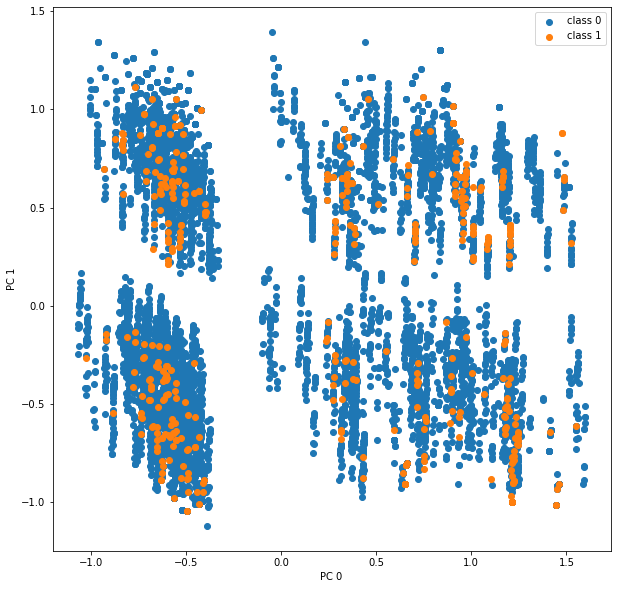

In [59]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_PCA1[(y_train==0),0],X_train_PCA1[(y_train==0),1],label = 'class 0')
ax.scatter(X_train_PCA1[(y_train==1),0],X_train_PCA1[(y_train==1),1],label = 'class 1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

In [60]:
# Use smote to deal with imbalance data
from imblearn.over_sampling import SMOTE
import imblearn

sm = SMOTE(random_state=42)
X_train_scaled_sm,y_train_sm = sm.fit_resample(X_train_scaled,y_train)
print(X_train.shape, y_train_sm.shape)

(8352, 186) (15822,)


In [61]:
## PCA component after SMOTE
PCA2 = PCA(n_components=2)
PCA2.fit(X_train_scaled_sm)
X_train_PCA2 = PCA2.transform(X_train_scaled_sm)

print(X_train_PCA2.shape)
print(y_train_sm.shape)

(15822, 2)
(15822,)


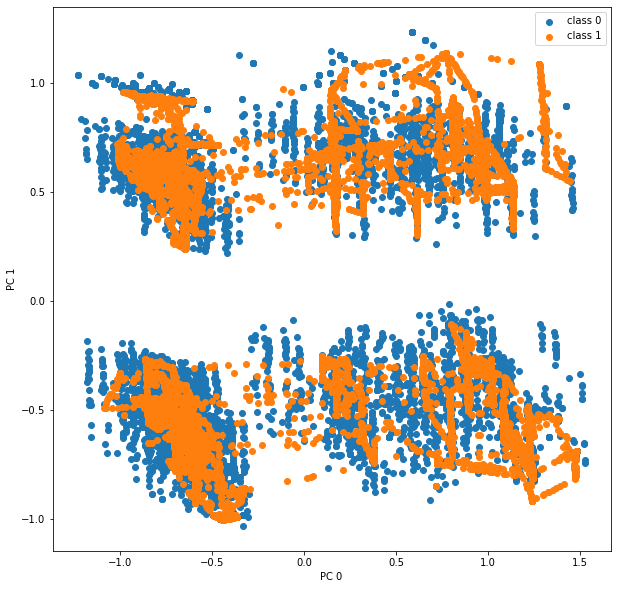

In [62]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_PCA2[(y_train_sm==0),0],X_train_PCA2[(y_train_sm==0),1],label = 'class 0')
ax.scatter(X_train_PCA2[(y_train_sm==1),0],X_train_PCA2[(y_train_sm==1),1],label = 'class 1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

In [63]:
#reassign the variable name

Z_train = X_train_scaled #unsmote set
Z_val= X_val_scaled      #validation set

Z_test = X_test_scaled #kaggle submission set

y_train = y_train     #unsmote set
y_val = y_test         #validation set


Z_train_sm = X_train_scaled_sm  #after smote
y_train_sm = y_train_sm    

# save the data
with open('./ML_data/Z_train.pickle', 'wb') as to_write:
    pickle.dump(Z_train, to_write)
with open('./ML_data/Z_val.pickle', 'wb') as to_write:
    pickle.dump(Z_val, to_write)
with open('./ML_data/Z_test.pickle', 'wb') as to_write:
    pickle.dump(Z_test, to_write)

with open('./ML_data/y_train.pickle', 'wb') as to_write:
    pickle.dump(y_train, to_write)
with open('./ML_data/y_val.pickle', 'wb') as to_write:
    pickle.dump(y_val, to_write)

with open('./ML_data/Z_train_sm.pickle', 'wb') as to_write:
    pickle.dump(Z_train_sm, to_write)
with open('./ML_data/y_train_sm.pickle', 'wb') as to_write:
    pickle.dump(y_train_sm, to_write)

with open('./ML_data/id.pickle', 'wb') as to_write:
    pickle.dump(id, to_write)

print(f'Unbalance set data shape: {Z_train.shape}, {y_train.shape}')
print(f'SMOTE data shape: {Z_train_sm.shape}, {y_train_sm.shape}')


Unbalance set data shape: (8352, 186), (8352,)
SMOTE data shape: (15822, 186), (15822,)
